# Prediction de la confusion d'un individu grâce à des données EEG

On s'intéresse ici à tester différentes approches pour classifier un signal EEG.
Si l'on regarde les Notebook présents sur Kaggle, il essaie pour la plupart de prédire la confusion (yes/no) en ajoutant les données demographic sur les individus qui regardent la vidéo.
En faisant ça ils apprennent des classifieurs qui ne se servent pas ou pas du signal EEG.
Dans ce notebook nous allons de tenter de classer la confusion par le seul traitement du signal EEG.
Rq : Les données n'étant pas nombreuses, il est difficile d'aller étudier les facteurs confondants (individu, vidéo) conjointements. Quelle serait la bonne méthode ? 

In [3]:
import numpy as np 
import pandas as pd
import random as rd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report 
from sklearn.svm import LinearSVC
from sklearn import metrics


import torch

import warnings
warnings.filterwarnings('ignore')


## A/ importation des données 

In [4]:
#starting the project
eeg_data = pd.read_csv('archive/EEG_data.csv')
info_data=pd.read_csv('archive/demographic_info.csv')
eeg_data.head()


,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [5]:

#on veut que chaque couple (sujet,video) soit un objet x
#les objets x sur lesquels on va travailler sont des matrices de taille (c,t) avec c le nombre de channels et t le nombre de points d'acquisition

#recuperation des valeurs de la colonne SubjectID
val_subjects = eeg_data['SubjectID'].unique()
val_videos = eeg_data['VideoID'].unique()

XY = []
for val1 in val_subjects:
    for val2 in val_videos:
        Xeeg_data = eeg_data[eeg_data['SubjectID']==val1]
        Xeeg_data = Xeeg_data[eeg_data['VideoID']==val2]
        y = Xeeg_data[['SubjectID','VideoID', 'predefinedlabel', 'user-definedlabeln']].head(1).to_numpy()
        y = y[0]
        Xeeg_data = Xeeg_data.drop(['SubjectID','VideoID','predefinedlabel', 'user-definedlabeln'],axis=1)
        Xeeg_data = Xeeg_data.to_numpy()
        xy = Xeeg_data, y
        XY.append(xy)
        



## B/ Première visualisation des données.

### Pour 1 individu, représenter le signal en fonction du temps 

In [5]:
X = XY[0][0]
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X-mean)/std


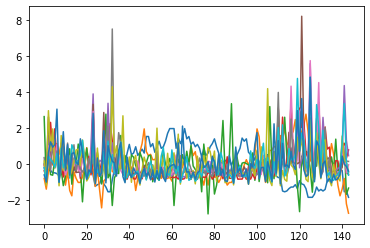

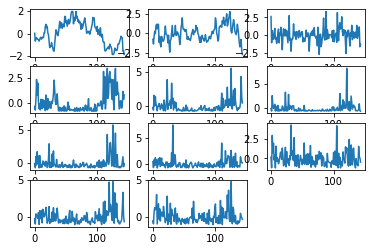

In [6]:
for i in range(X.shape[1]):
    x = X[:,i]
    plt.plot(x)
plt.show() 

#même chose mais en affichant les courbes côte à côte pour chaque channel
for i in range(X.shape[1]):
    x = X[:,i]
    plt.subplot(4,3,i+1)
    plt.plot(x)



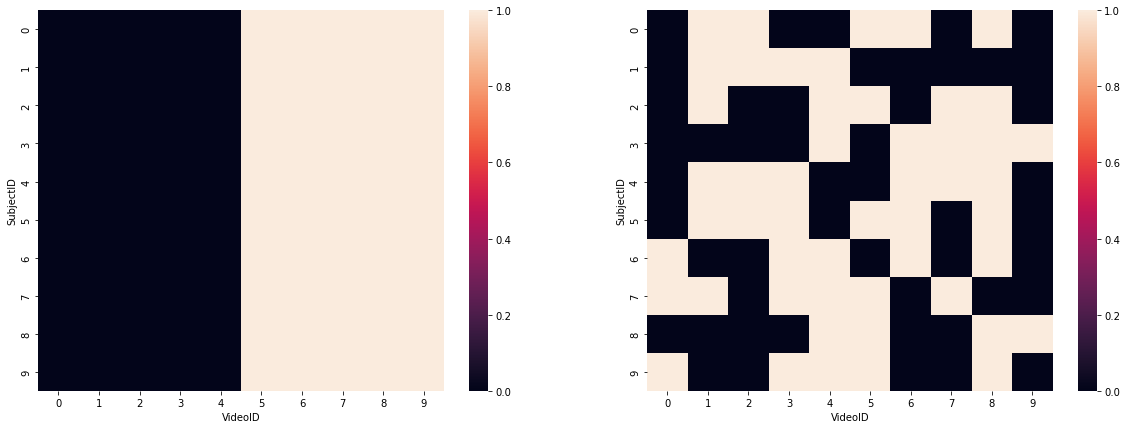

In [7]:
#regarder la distribution des 0 et des 1 par individus et par vidéos 
Obj_confusion_matrix = np.zeros((10,10))
Sub_confusion_matrix = np.zeros((10,10))
for x,y in XY:
    Row_index = int(y[0])
    Col_index = int(y[1])
    Obj_confusion_matrix[Row_index][Col_index] = y[2]
    Sub_confusion_matrix[Row_index][Col_index] = y[3]

fig, ax = plt.subplots(1,2,figsize=(20,7))
sns.heatmap(Obj_confusion_matrix,ax=ax[0])
sns.heatmap(Sub_confusion_matrix,ax=ax[1])
ax[0].set_xlabel('VideoID')
ax[0].set_ylabel('SubjectID')
ax[1].set_xlabel('VideoID')
ax[1].set_ylabel('SubjectID')
plt.show()



... Les labels données a priori sur les vidéos ne sont pas ceux que rapportent les individus. On peut déjà se dire que les données ne vont pas être facile à traiter si les vidéos ne sont pas clairement confusing. 

In [8]:
# #on regarde les corrélations entre la target et les données (heatmap)

# plt.figure(figsize = (15,15))
# cor_matrix = XY.corr()
# sns.heatmap(cor_matrix,annot=True)

## C/ prétraitements / Feature engineering

On va tester plusieurs manières différentes de traiter les n channels:
* concaténation pour former des matrices de n colonnes 
* concatenation pour former un seul channel n fois plus long
* channel par channel (puis méthode d'ensemble)

In [8]:
# for next time : trouver une méthode qui permettent de pas avoir à switcher entre les pack et unpack (ou méthode équivalente d'un module)
def unpacking(XY):
    X,Y = [],[]
    for x,y in XY:
        X.append(x)
        Y.append(y)
    return X,Y

def packing(X,Y):
    if type(X) != list or type(Y) != list:
        raise TypeError('the argument was not a list')
    for i in range(len(X)):
        XY.append((X[i],Y[i]))
    return XY


In [11]:
#randomisation du jeu de données
def shuffle_data(data):
    return rd.shuffle(data)


#on garde seulement la target qui nous intéresse (en priorité le 'user-definedlabeln' )
def select_target(Y):
    new_Y = []
    for y in Y:
        y = y[3]
        new_Y.append(y)
    return new_Y

# Normalisation par channels (mais attention, si on normalise pour chaque enregistrement on perd de l'information, il faut normaliser avant, sur tout le channel enregistré ?)
def normalize(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X-mean)/(std+0.00000001)
    return X

# diminution du bruit (binning, lissage)
def binning(X):
    pass


#### Feature engineering

On peut faire cela grâce à la librairie tsfel qui traitent les séries temporelles 

In [12]:
#Ordre des colonnes (Attention, Mediation, Raw, Delta, Theta, Alpha1, Alpha2, Beta1, Beta2, Gamma1, Gamma2)


#selection du channel étudié
def select_colonne(X,i):
    new_X = []
    for x in X:
        x = x[:,i]
        new_X.append(x)
    return new_X


# use of tsfel library for feature extraction
import tsfel
def features_extraction(x):
    x = pd.DataFrame(np.hstack(x)) 
    cfg_file = tsfel.get_features_by_domain('temporal')                                                        # If no argument is passed retrieves all available features
    X_train = tsfel.time_series_features_extractor(cfg_file, x, window_size=100, verbose=0)
    return X_train


#on créé la matrice features qui representent chaque enregistrement grâce à des caractéristiques du signal
def create_features(X):
    features = []
    for x in X:
        one_seq_features = features_extraction(x)
        one_seq_features = np.array(one_seq_features).flatten()
        features.append(one_seq_features)
    features = np.array(features)
    return features


Tsfel permet d'extraire un certain nombre de features du signal, on va voir dans notre cas lesquelles sont importantes pour faire de la selection
* 1/ approche par corrélations (non-traité ici)
* 2/ approche grâce au FeatureSelector de sklearn

In [13]:
from sklearn.feature_selection import SequentialFeatureSelector

def feature_selection(X,Y,n_features = 6):
    estimator = LinearSVC() # on peut changer l'estimateur
    selector = SequentialFeatureSelector(estimator, n_features_to_select= n_features, direction='forward')
    selector = selector.fit(X, Y)
    Xnew = selector.transform(X) # on filtre les données
    # print("Ancienne dimensions : ",X.shape)
    # print("Nouvelles dimensions : ",Xnew.shape)
    return Xnew


.... Sans utiliser tsfel et avec du savoir expert, on pourrait imaginer extraire des signatures du signal (features) intéressantes à la main
<br/>
Approche non testée ici.

In [14]:
#création de variables d'intérets à partir du signal
def features_crea(X):
    features = np.empty((0,2))
    for signal in X:
        mean = signal.mean()
        std = signal.std()
        features = np.append(features,[[mean,std]],axis=0)
        # deriv = np.diff(signal)
        # signal = np.append(signal,mean)
        # signal = np.append(signal,std)
    return features

### run pretraitement

In [ ]:
from copy import copy

XYbis = copy(XY)
rd.seed(2026)
rd.shuffle(XYbis)
X,Y = unpacking(XYbis)
fY = select_target(Y)
fX = select_colonne(X,4)
features = create_features(fX)
features = normalize(features)
features = feature_selection(features,fY)
X_train, X_test, y_train, y_test = train_test_split(features, fY, test_size=0.2, random_state=2022)



## D/ Algorithmes supervisés

## SVM

On regarde rapidement le résultat de notre SVM 

In [15]:
#1ere estimation de l'accuracy

# SVMmod = LinearSVC()
# SVMmod.fit(X_train,y_train)
# y_hat = SVMmod.predict(X_test)
# metrics.accuracy_score(y_test,y_hat)

from sklearn.model_selection import cross_val_score
SVMmod = LinearSVC()
n_fold = 10
scores = cross_val_score(SVMmod, X_train, y_train, cv=n_fold, scoring='accuracy') 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.74 (+/- 0.21)


On va utiliser le SVM pour continuer d'améliorer les prétraitements :
- choisir le nombre optimal de features à garder  
- choisir les channels que l'on veut garder
<br/>
<br/>
On va réaliser pour cela des cross-validation successives. 
<br/>
Rq : on fait d'abord un train_test_split comme ça on pourra ensuite réellement évaluer notre meilleur modèle, mais étant donné le faible nombres de données, on aurait pu ne pas faire de jeu de test. 

In [16]:
#cross validation pour regarder les performances selon différents traitements
from sklearn.model_selection import cross_val_score

def run_pretraitement(XY,channels, nb_features=6):    
    rd.seed(2026)
    XYbis = copy(XY)
    rd.shuffle(XYbis)
    X,Y = unpacking(XYbis)
    fY = select_target(Y)
    fX = select_colonne(X,channels)
    features = create_features(fX)
    features = normalize(features)
    features = feature_selection(features,fY, nb_features)
    X_train, X_test, y_train, y_test = train_test_split(features, fY, test_size=0.2, random_state=2022)
    return X_train, X_test, y_train, y_test

In [ ]:
nb_features = X_train.shape[1]
nb_features_scores = []
for i in range(1,nb_features-1):
    X_train, X_test, y_train, y_test = run_pretraitement(XY,4,i)
    SVMmod = LinearSVC()
    n_fold = 10
    scores = cross_val_score(SVMmod, X_train, y_train, cv=n_fold, scoring='accuracy') # tout est caché dedans :)
    nb_features_scores = np.append(nb_features_scores,scores.mean())

    

In [2]:
print(nb_features_scores)

NameError: name 'nb_features_scores' is not defined

In [ ]:

channels_scores = []
for i in range(11):
    print("Channel : ",i)
    X_train, X_test, y_train, y_test = run_pretraitement(XY,i)
    SVMmod = LinearSVC()
    n_fold = 10
    scores = cross_val_score(SVMmod, X_train, y_train, cv=n_fold, scoring='accuracy') 
    channels_scores = np.append(channels_scores,scores.mean())


In [1]:
print(channels_scores)

NameError: name 'channels_scores' is not defined

On détecte ainsi les channels qui ont une valeur prédictive intéressante. 
On va maintenant tester plusieurs choses pour améliorer la prédictivité du modèle:
- combiner les différents channels plutot que d'en regarder un seul 
- méthodes d'ensemble 


Avant de continuer, quelques remarques:
 
* RQ1 : Sachant que les features intéressantes ont été trouvé pour un channel donné
* RQ2 : je suis surement entrain de créer un biais de selection par comparaison multiple.
* RQ3 : le processus est sans doute largement améliorable; il aurait fallut s'interesser directement à tous les channels et faire une sorte de gridsearch.
* RQ4 : les features du signal qui ont été sélectionnées pourraient sans doute être améliorées.
<br/>
<br/>

Construisons la matrice des features intéressantes sur les channels et features intéressants :
* [1,3,4]
* [False False False  True False False  True  True False False  True False False False  True False False  True]
 

In [ ]:
#important de farder les mêmes seed pour ne pas changer le jeu de test 
''' il aurait fallu diviser en 2 dès le début et ne plus y toucher jusqu'à la fin '''
# XYbis = copy(XY)
rd.seed(2026)
rd.shuffle(XYbis)
X,Y = unpacking(XYbis)
fY = select_target(Y)
fX = select_colonne(X,[1,3,4])


#bon là c'est vraiment VRAIMENT moche... il faudrait utiliser tsfel pour synchroniser les signaux 
'''
par contre intéressant de constater que pour pouvoir synchroniser les signaux, il faut penser à mettre des marqueurs quand on recueille les données 
(par exemple  montrer une image complétement différente dont on sait qu'on va pouvoir le distinguer dans l'enregistrement cérébral)
'''
for i in range(len(fX)):
    fX[i] = fX[i][:100,:]
    
features = create_features(fX)
features = np.array(features)

Bon... ça donnera rien de mieux !

## CNN 

Attention, notre jeu de donnée ne comportant pas beaucoup d'exemples en comparaison avec la dimension des objets, il va falloir faire très attention au surapprentissage (Il fa falloir ajouter un terme de régularisation de manière certaine)
<br/>
<br/>
<br/>
Testons un 1er CNN prenant en entrée une série temporelles trivariées (input = 100 x 3)
<br/>
<br/>
Il est raisonnable de penser que les interactions entre les channels sont importantes, on va donc faire une convolution 2D sur cet input avec un kernel de 3 x k, mais avec un padding (le kernel le plus à gauche prend les valeur de la colonne de droite pour se compléter et inversement) pour que le kernel s'applique sur chacune des trois channels 

In [15]:
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import time
import os
from torch.utils.data import TensorDataset, DataLoader,Dataset
import matplotlib.pyplot as plt


In [16]:
X,Y = unpacking(XY)

Y = select_target(Y)
X = select_colonne(X,[1,3,4])
for i in range(len(X)):
    X[i] = X[i][:110,:]
    X[i] = normalize(X[i])


data = []
for i in range(len(X)):
    data.append((X[i],Y[i]))


data_train, data_test = train_test_split(data,test_size = 0.2, random_state=2022, shuffle=True)

In [139]:

# pourquoi c'est important de typer les données ?? 
class EEGDataset(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        data = self.dataset[index]
        recording = data[0]
        confusion = torch.from_numpy(np.array(data[1]))
        confusion = torch.tensor(confusion, dtype=torch.long)
        if self.transform is not None:
            recording = self.transform(recording.astype(np.float32))
            #confusion = self.transform(confusion.astype(np.float32))
        return recording,confusion

    def __len__(self):
        return len(self.dataset)

transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])


In [232]:
Tdata_train = EEGDataset(data_train, transform)
Tdata_test = EEGDataset(data_test,transform)

# batch_size = square(nb_exemples ?) quand est-ce que ça a du sens ? 
torch.manual_seed(1)
batch_size= 5
Tdata_train_loader = DataLoader(Tdata_train, batch_size=batch_size, shuffle=True)
Tdata_test_loader = DataLoader(Tdata_test, batch_size=batch_size, shuffle=True)


In [218]:
# il faudrait essayer de ne pas utiliser le dataloader aussi pour mieux comprendre...
print(len(Tdata_train_loader))
for x,y in Tdata_train_loader:                           # boucle sur les batchs  
            print(x.shape)

4
torch.Size([20, 1, 110, 3])
torch.Size([20, 1, 110, 3])
torch.Size([20, 1, 110, 3])
torch.Size([20, 1, 110, 3])


### Construction 1er modèle CNN...

In [233]:
class MyCNN(nn.Module):
    def __init__(self): # à paramétrer ensuite 
        super().__init__()
        #est-ce que circular fais bien ce que je veux ?
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size = (11,3), padding=(5,1) , padding_mode= 'circular') 
        self.pool1 = nn.MaxPool2d(kernel_size = (10,1))
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        #1ere convolution
        #[(W−K+2P)/S]+1 avec input = W =  110, kernel = K = 11, stride = S = 1, padding = P = 5
        #[(110-11+2*5)/1]+1 = 110
        #et [(H−K+2P)/S]+1 avec input = W =  3, kernel = K = 3, stride = S = 1, padding = P = 1
        #[(3-3+2*1)/1]+1 = 3

        #1er maxpooling
        #[(W−K+2P)/S]+1 avec input = W =  110, kernel = K = 10, stride = S = 10, padding = P = 0
        #[(110-10+2*0)/10]+1 = 11
        #et [(H−K+2P)/S]+1 avec input = W =  3, kernel = K = 1, stride = S = 3, padding = P = 0
        #[(3-1+2*0)/1]+1 = 3
        
        self.lin1 = nn.Linear(8*11*3,10)
        self.lin2 = nn.Linear(10, 2)
        
        self.features   = nn.Sequential(self.conv1,nn.ReLU(),self.pool1)
        self.classifier = nn.Sequential(self.lin1,nn.ReLU(),self.lin2)
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x.view(x.size(0), -1))
        return x

In [234]:
device = 'cpu'
def accuracy(yhat,y):
    # y encode les indexes, s'assurer de la bonne taille de tenseur
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).double().mean()
    
def train(model,epochs,train_loader,test_loader):
    optim = torch.optim.Adam(model.parameters(),lr=1e-3)    # choix optimizer
    model = model.to(device)
    loss = nn.CrossEntropyLoss()                           # choix loss
    print(f"running {model.name}")
    loss_train = []
    loss_test = []
    acc_train = []
    acc_test = []
    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x,y in train_loader:                            # boucle sur les batchs
            optim.zero_grad()
            x,y = x.to(device), y.to(device)              
            yhat = model(x)
            l = loss(yhat,y)
            l.backward()
            optim.step()
            cumloss += l*len(x)                             # attention, il peut y avoir un batch + petit (le dernier)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
        loss_train.append(cumloss/count)
        acc_train.append(cumacc/count)
        
        if epoch % 1 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x,y in test_loader:
                    x,y = x.to(device), y.to(device)
                    yhat = model(x)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
            #print('accuracy/test' + str(cumacc/count))
            loss_test.append(cumloss/count)
            acc_test.append(cumacc/count)
    return loss_train, loss_test, acc_train, acc_test
    

On essaie d'apprendre le premier modèle
<br/>
Affichage de la loss / accuracy... ça ne fonctionne pas bien.
<br/>
Encore une fois il est surement très dur (voir impossible ? erreur de Bayes) d'aller faire mieux vu le nombre de données et la difficulté de la tâche.
<br/>
On voit d'ailleurs avec la courbe de loss test que le modèle au dela d'overfitter après 15 epochs, n'arrive même pas à apprendre bien dès le début.
<br/>
<br/>

Que faire si l'on veut quand même essayer de faire mieux ?
- changer le preprocessing / la création de features de qualités ? 
- changer l'architecture du modèle ? 
- changer les paramètres d'apprentissages (learning rate, taille de batches, nb_epochs, optimizer, )
- combattre l'overfitting (regularisation / dropout / data augmentation / )

running DetectConfCNN_V1-Tue Dec 27 23:47:45 2022


100%|██████████| 50/50 [00:01<00:00, 25.92it/s]


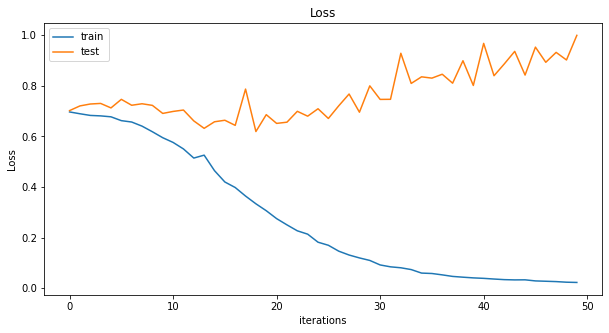

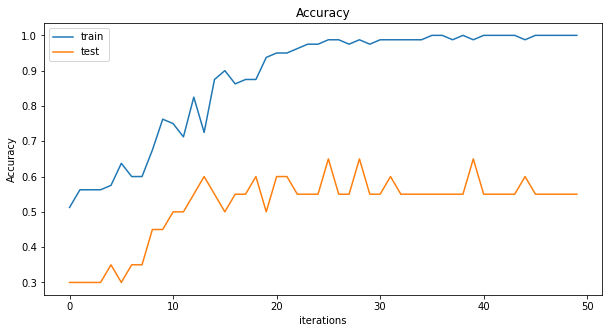

In [240]:
n_epoch = 50
model = MyCNN()
model.name = "DetectConfCNN_V1-"+time.asctime()
loss_train, loss_test, acc_train, acc_test = train(model,n_epoch,Tdata_train_loader,Tdata_test_loader)

for i in range(len(loss_train)):
    loss_train[i] = np.array(loss_train[i].detach())
    loss_test[i] = np.array(loss_test[i].detach())
    
    acc_train[i] = np.array(acc_train[i].detach())
    acc_test[i] = np.array(acc_test[i].detach())

    # plot loss with matplotlib
plt.figure(figsize=(10,5))
plt.title("Loss") 
plt.plot(loss_train,label="train")
plt.plot(loss_test,label="test")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# plot accuracy with matplotlib
plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(acc_train,label="train")
plt.plot(acc_test,label="test")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## D/ Classification non supervisée:

--> définition de métriques différentes entre 2 enregistrements 

...
<br/>
...
<br/>
<br/>
Je ne ferai finalement pas ces tests. En effet je pense que les données étant ce qu'elles sont, il sera dur de faire mieux que ce qui a été déjà fait. Je testerai d'autres approches mais sur d'autres jeux de données.